In [1]:
# imports
import csv
import os
import numpy as np
#import pandas as pd
import torch
import torch.nn as nn
#import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from albumentations import Compose as AlbCompose, Resize as AlbResize, Normalize as AlbNormalize
import matplotlib.pyplot as plt
import datetime

# Import DeepLabV3+ Model
from segmentation_models_pytorch import DeepLabV3Plus

c:\Users\ssrir\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Define device and initialize DeepLabV3+ Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=2)
model.to(device)

# Function to save the initial state of the model
def save_initial_model_state():
    torch.save(model.state_dict(), 'initial_deeplab_model.pth')
    print("Initial model state saved!")

# Save the initial state of the model before training
save_initial_model_state()


# load the model
def load_initial_model_state(model, filepath='initial_deeplab_model.pth'):
    model.load_state_dict(torch.load(filepath))
    model.eval()  # Set the model to evaluation mode
    print("Initial model state loaded!")


# Training setup
num_epochs = 50
learning_rate = 0.001
improvement_tolerance = 0.0001
patience = 3
criterion = nn.CrossEntropyLoss()

# Initialize metric lists to store the results.
results = {}
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_jaccards, test_jaccards = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []
train_dices, test_dices = [], []

# Data transformations
def get_transforms():
    return AlbCompose([
        AlbResize(height=256, width=256, interpolation=1),  # 1 corresponds to 'bilinear'
        AlbNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])


# Dataset Class
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        with open(file_list, 'r') as f:
            self.image_filenames = f.read().splitlines()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_filenames[idx] + '.jpg')).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, self.image_filenames[idx] + '.png')).convert("L")

        # Convert images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)  # Use the correct keyword arguments
            image, mask = augmented['image'], augmented['mask']

        mask = (mask > 0).astype(np.int64)  # Convert mask to binary (0 or 1)

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change shape to C x H x W
        mask = torch.tensor(mask, dtype=torch.long)  # Keep mask as long for class indices

        return image, mask



# Load datasets and define data loaders
train_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt', transform=get_transforms())
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/test.txt', transform=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Metrics functions
def calculate_accuracy(preds, targets):
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

def calculate_metrics(preds, targets):
    """Calculate Jaccard, Precision, Recall, Accuracy, and Dice Coefficient for binary classification."""
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    jaccard = jaccard_score(targets_flat, preds_flat, average='binary')
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    accuracy = (preds_flat == targets_flat).sum() / len(targets_flat)

    # Dice Coefficient as F1 Score in binary case
    dice = f1_score(targets_flat, preds_flat, average='binary')

    return jaccard, precision, recall, accuracy, dice



# Optimizer and Scheduler Configuration
optimizer_configs = {
    'adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 1e-3, 'betas': (0.9, 0.999)},
        'scheduler': lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    },
    'sgd': {
        'class': torch.optim.SGD,
        'params': {'lr': 1e-2, 'momentum': 0.9},
        'scheduler': lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    },
    'rmsprop': {
        'class': torch.optim.RMSprop,
        'params': {'lr': 1e-4, 'alpha': 0.99},
        'scheduler': lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    }
}

def create_optimizer_and_scheduler(model, optimizer_choice='adam'):
    """
    Create and return the optimizer and scheduler based on the optimizer_choice.
    """
    optimizer_config = optimizer_configs.get(optimizer_choice)
    if optimizer_config is None:
        raise ValueError(f"Invalid optimizer choice: {optimizer_choice}")
    
    optimizer = optimizer_config['class'](model.parameters(), **optimizer_config['params'])
    scheduler = optimizer_config['scheduler'](optimizer)
    return optimizer, scheduler


def train_and_evaluate(model, train_loader, test_loader, optimizer_choice='adam'):
    # Initialize the results dictionary to store metrics
    results = {
        'train_losses': [],
        'test_losses': [],
        'train_accuracies': [],
        'test_accuracies': [],
        'train_jaccards': [],
        'test_jaccards': [],
        'train_precisions': [],
        'test_precisions': [],
        'train_recalls': [],
        'test_recalls': [],
        'train_dices': [],
        'test_dices': [],
    }
    best_test_loss = float('inf')
    early_stop_counter = 0

    # Create optimizer and scheduler based on the chosen optimizer
    optimizer, scheduler = create_optimizer_and_scheduler(model, optimizer_choice)

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        all_train_jaccard, all_train_precision, all_train_recall, all_train_dice = [], [], [], []

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_acc += calculate_accuracy(preds, masks).item()

            jaccard, precision, recall, _, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
            all_train_jaccard.append(jaccard)
            all_train_precision.append(precision)
            all_train_recall.append(recall)
            all_train_dice.append(dice)

        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)
        avg_train_jaccard = sum(all_train_jaccard) / len(all_train_jaccard)
        avg_train_precision = sum(all_train_precision) / len(all_train_precision)
        avg_train_recall = sum(all_train_recall) / len(all_train_recall)
        avg_train_dice = sum(all_train_dice) / len(all_train_dice)

        results['train_losses'].append(avg_train_loss)
        results['train_accuracies'].append(avg_train_acc)
        results['train_jaccards'].append(avg_train_jaccard)
        results['train_precisions'].append(avg_train_precision)
        results['train_recalls'].append(avg_train_recall)
        results['train_dices'].append(avg_train_dice)

        model.eval()
        with torch.no_grad():
            running_test_loss, running_test_acc = 0.0, 0.0
            all_jaccard, all_precision, all_recall, all_accuracy, all_dice = [], [], [], [], []

            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                test_loss = criterion(outputs, masks)
                running_test_loss += test_loss.item()

                preds = torch.argmax(outputs, dim=1)
                jaccard, precision, recall, accuracy, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
                all_jaccard.append(jaccard)
                all_precision.append(precision)
                all_recall.append(recall)
                all_accuracy.append(accuracy)
                all_dice.append(dice)

            avg_test_loss = running_test_loss / len(test_loader)
            avg_test_acc = sum(all_accuracy) / len(all_accuracy)
            avg_jaccard = sum(all_jaccard) / len(all_jaccard)
            avg_precision = sum(all_precision) / len(all_precision)
            avg_recall = sum(all_recall) / len(all_recall)
            avg_dice = sum(all_dice) / len(all_dice)

            results['test_losses'].append(avg_test_loss)
            results['test_accuracies'].append(avg_test_acc)
            results['test_jaccards'].append(avg_jaccard)
            results['test_precisions'].append(avg_precision)
            results['test_recalls'].append(avg_recall)
            results['test_dices'].append(avg_dice)

            print(f"Epoch [{epoch + 1}/{num_epochs}]:")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

            # Save the best model for the current optimizer
            if avg_test_loss < best_test_loss - improvement_tolerance:
                best_test_loss = avg_test_loss
                early_stop_counter = 0
                model_filename = f'best_model_{optimizer_choice}.pth' 
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'epoch': epoch + 1,
                            'test_loss': avg_test_loss,
                            'test_accuracy': avg_test_acc,
                            'jaccard': avg_jaccard,
                            'precision': avg_precision,
                            'recall': avg_recall,
                            'dice': avg_dice}, model_filename)
                print(f"Best model for {optimizer_choice.upper()} saved!")
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to lack of improvement.")
                    break
        scheduler.step()

    return results

# Experiment loop
optimizer_choices = ['adam', 'sgd', 'rmsprop']

for optimizer_choice in optimizer_choices:
    print(f"\nExperimenting with {optimizer_choice.upper()} optimizer:")
    # Reset model weights to initial state before each experiment
    #load_initial_model_state(model)
    model.load_state_dict(torch.load('initial_deeplab_model.pth', weights_only=True))
    experiment_results = train_and_evaluate(model, train_loader, test_loader, optimizer_choice=optimizer_choice)
    results[optimizer_choice] = experiment_results


Initial model state saved!

Experimenting with ADAM optimizer:


Epoch 1/50: 100%|██████████| 59/59 [04:05<00:00,  4.16s/it]


Epoch [1/50]:
  Train Loss: 0.1337, Train Accuracy: 0.9534
  Test Loss: 0.0808, Test Accuracy: 0.9730
Best model for ADAM saved!


Epoch 2/50: 100%|██████████| 59/59 [03:53<00:00,  3.96s/it]


Epoch [2/50]:
  Train Loss: 0.0713, Train Accuracy: 0.9741
  Test Loss: 0.0770, Test Accuracy: 0.9746
Best model for ADAM saved!


Epoch 3/50: 100%|██████████| 59/59 [04:16<00:00,  4.34s/it]


Epoch [3/50]:
  Train Loss: 0.0644, Train Accuracy: 0.9768
  Test Loss: 0.1115, Test Accuracy: 0.9592


Epoch 4/50: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it]


Epoch [4/50]:
  Train Loss: 0.0584, Train Accuracy: 0.9792
  Test Loss: 0.0603, Test Accuracy: 0.9821
Best model for ADAM saved!


Epoch 5/50: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Epoch [5/50]:
  Train Loss: 0.0563, Train Accuracy: 0.9796
  Test Loss: 0.0593, Test Accuracy: 0.9811
Best model for ADAM saved!


Epoch 6/50: 100%|██████████| 59/59 [04:08<00:00,  4.21s/it]


Epoch [6/50]:
  Train Loss: 0.0522, Train Accuracy: 0.9806
  Test Loss: 0.0610, Test Accuracy: 0.9817


Epoch 7/50: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it]


Epoch [7/50]:
  Train Loss: 0.0483, Train Accuracy: 0.9826
  Test Loss: 0.0514, Test Accuracy: 0.9832
Best model for ADAM saved!


Epoch 8/50: 100%|██████████| 59/59 [04:06<00:00,  4.18s/it]


Epoch [8/50]:
  Train Loss: 0.0372, Train Accuracy: 0.9864
  Test Loss: 0.0399, Test Accuracy: 0.9865
Best model for ADAM saved!


Epoch 9/50: 100%|██████████| 59/59 [06:39<00:00,  6.77s/it]


Epoch [9/50]:
  Train Loss: 0.0319, Train Accuracy: 0.9886
  Test Loss: 0.0374, Test Accuracy: 0.9875
Best model for ADAM saved!


Epoch 10/50: 100%|██████████| 59/59 [04:11<00:00,  4.26s/it]


Epoch [10/50]:
  Train Loss: 0.0298, Train Accuracy: 0.9895
  Test Loss: 0.0374, Test Accuracy: 0.9875


Epoch 11/50: 100%|██████████| 59/59 [04:08<00:00,  4.20s/it]


Epoch [11/50]:
  Train Loss: 0.0284, Train Accuracy: 0.9896
  Test Loss: 0.0372, Test Accuracy: 0.9879
Best model for ADAM saved!


Epoch 12/50: 100%|██████████| 59/59 [04:09<00:00,  4.22s/it]


Epoch [12/50]:
  Train Loss: 0.0276, Train Accuracy: 0.9900
  Test Loss: 0.0364, Test Accuracy: 0.9882
Best model for ADAM saved!


Epoch 13/50: 100%|██████████| 59/59 [04:12<00:00,  4.29s/it]


Epoch [13/50]:
  Train Loss: 0.0260, Train Accuracy: 0.9905
  Test Loss: 0.0364, Test Accuracy: 0.9884


Epoch 14/50: 100%|██████████| 59/59 [04:12<00:00,  4.27s/it]


Epoch [14/50]:
  Train Loss: 0.0256, Train Accuracy: 0.9906
  Test Loss: 0.0372, Test Accuracy: 0.9883


Epoch 15/50: 100%|██████████| 59/59 [04:11<00:00,  4.26s/it]


Epoch [15/50]:
  Train Loss: 0.0244, Train Accuracy: 0.9911
  Test Loss: 0.0355, Test Accuracy: 0.9886
Best model for ADAM saved!


Epoch 16/50: 100%|██████████| 59/59 [09:37<00:00,  9.78s/it]   


Epoch [16/50]:
  Train Loss: 0.0235, Train Accuracy: 0.9914
  Test Loss: 0.0358, Test Accuracy: 0.9887


Epoch 17/50: 100%|██████████| 59/59 [03:54<00:00,  3.97s/it]


Epoch [17/50]:
  Train Loss: 0.0239, Train Accuracy: 0.9913
  Test Loss: 0.0355, Test Accuracy: 0.9887


Epoch 18/50: 100%|██████████| 59/59 [03:59<00:00,  4.07s/it]


Epoch [18/50]:
  Train Loss: 0.0241, Train Accuracy: 0.9911
  Test Loss: 0.0352, Test Accuracy: 0.9887
Best model for ADAM saved!


Epoch 19/50: 100%|██████████| 59/59 [04:12<00:00,  4.27s/it]


Epoch [19/50]:
  Train Loss: 0.0243, Train Accuracy: 0.9909
  Test Loss: 0.0356, Test Accuracy: 0.9887


Epoch 20/50: 100%|██████████| 59/59 [04:13<00:00,  4.29s/it]


Epoch [20/50]:
  Train Loss: 0.0241, Train Accuracy: 0.9911
  Test Loss: 0.0347, Test Accuracy: 0.9888
Best model for ADAM saved!


Epoch 21/50: 100%|██████████| 59/59 [04:16<00:00,  4.35s/it]


Epoch [21/50]:
  Train Loss: 0.0229, Train Accuracy: 0.9916
  Test Loss: 0.0356, Test Accuracy: 0.9885


Epoch 22/50: 100%|██████████| 59/59 [04:05<00:00,  4.15s/it]


Epoch [22/50]:
  Train Loss: 0.0235, Train Accuracy: 0.9912
  Test Loss: 0.0359, Test Accuracy: 0.9886


Epoch 23/50: 100%|██████████| 59/59 [04:16<00:00,  4.34s/it]


Epoch [23/50]:
  Train Loss: 0.0233, Train Accuracy: 0.9914
  Test Loss: 0.0361, Test Accuracy: 0.9885
Early stopping at epoch 23 due to lack of improvement.

Experimenting with SGD optimizer:


Epoch 1/50: 100%|██████████| 59/59 [04:03<00:00,  4.13s/it]


Epoch [1/50]:
  Train Loss: 0.1734, Train Accuracy: 0.9363
  Test Loss: 0.0760, Test Accuracy: 0.9723
Best model for SGD saved!


Epoch 2/50: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it]


Epoch [2/50]:
  Train Loss: 0.0685, Train Accuracy: 0.9741
  Test Loss: 0.0598, Test Accuracy: 0.9788
Best model for SGD saved!


Epoch 3/50: 100%|██████████| 59/59 [04:07<00:00,  4.20s/it]


Epoch [3/50]:
  Train Loss: 0.0508, Train Accuracy: 0.9806
  Test Loss: 0.0460, Test Accuracy: 0.9839
Best model for SGD saved!


Epoch 4/50: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Epoch [4/50]:
  Train Loss: 0.0409, Train Accuracy: 0.9842
  Test Loss: 0.0459, Test Accuracy: 0.9845
Best model for SGD saved!


Epoch 5/50: 100%|██████████| 59/59 [04:09<00:00,  4.23s/it]


Epoch [5/50]:
  Train Loss: 0.0375, Train Accuracy: 0.9851
  Test Loss: 0.0434, Test Accuracy: 0.9853
Best model for SGD saved!


Epoch 6/50: 100%|██████████| 59/59 [02:37<00:00,  2.67s/it]


Epoch [6/50]:
  Train Loss: 0.0351, Train Accuracy: 0.9863
  Test Loss: 0.0406, Test Accuracy: 0.9861
Best model for SGD saved!


Epoch 7/50: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


Epoch [7/50]:
  Train Loss: 0.0326, Train Accuracy: 0.9871
  Test Loss: 0.0425, Test Accuracy: 0.9853


Epoch 8/50: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


Epoch [8/50]:
  Train Loss: 0.0290, Train Accuracy: 0.9885
  Test Loss: 0.0394, Test Accuracy: 0.9867
Best model for SGD saved!


Epoch 9/50: 100%|██████████| 59/59 [02:42<00:00,  2.75s/it]


Epoch [9/50]:
  Train Loss: 0.0277, Train Accuracy: 0.9891
  Test Loss: 0.0395, Test Accuracy: 0.9865


Epoch 10/50: 100%|██████████| 59/59 [02:59<00:00,  3.04s/it]


Epoch [10/50]:
  Train Loss: 0.0271, Train Accuracy: 0.9892
  Test Loss: 0.0392, Test Accuracy: 0.9868
Best model for SGD saved!


Epoch 11/50: 100%|██████████| 59/59 [02:59<00:00,  3.04s/it]


Epoch [11/50]:
  Train Loss: 0.0267, Train Accuracy: 0.9894
  Test Loss: 0.0388, Test Accuracy: 0.9867
Best model for SGD saved!


Epoch 12/50: 100%|██████████| 59/59 [02:53<00:00,  2.94s/it]


Epoch [12/50]:
  Train Loss: 0.0269, Train Accuracy: 0.9893
  Test Loss: 0.0391, Test Accuracy: 0.9868


Epoch 13/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Epoch [13/50]:
  Train Loss: 0.0271, Train Accuracy: 0.9892
  Test Loss: 0.0383, Test Accuracy: 0.9871
Best model for SGD saved!


Epoch 14/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Epoch [14/50]:
  Train Loss: 0.0263, Train Accuracy: 0.9896
  Test Loss: 0.0386, Test Accuracy: 0.9871


Epoch 15/50: 100%|██████████| 59/59 [02:54<00:00,  2.96s/it]


Epoch [15/50]:
  Train Loss: 0.0256, Train Accuracy: 0.9898
  Test Loss: 0.0384, Test Accuracy: 0.9871


Epoch 16/50: 100%|██████████| 59/59 [02:55<00:00,  2.97s/it]


Epoch [16/50]:
  Train Loss: 0.0262, Train Accuracy: 0.9896
  Test Loss: 0.0386, Test Accuracy: 0.9869
Early stopping at epoch 16 due to lack of improvement.

Experimenting with RMSPROP optimizer:


Epoch 1/50: 100%|██████████| 59/59 [02:53<00:00,  2.94s/it]


Epoch [1/50]:
  Train Loss: 0.1634, Train Accuracy: 0.9563
  Test Loss: 0.0765, Test Accuracy: 0.9822
Best model for RMSPROP saved!


Epoch 2/50: 100%|██████████| 59/59 [02:55<00:00,  2.98s/it]


Epoch [2/50]:
  Train Loss: 0.0693, Train Accuracy: 0.9801
  Test Loss: 0.0484, Test Accuracy: 0.9866
Best model for RMSPROP saved!


Epoch 3/50: 100%|██████████| 59/59 [02:48<00:00,  2.86s/it]


Epoch [3/50]:
  Train Loss: 0.0472, Train Accuracy: 0.9856
  Test Loss: 0.0495, Test Accuracy: 0.9839


Epoch 4/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Epoch [4/50]:
  Train Loss: 0.0376, Train Accuracy: 0.9882
  Test Loss: 0.0428, Test Accuracy: 0.9859
Best model for RMSPROP saved!


Epoch 5/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Epoch [5/50]:
  Train Loss: 0.0295, Train Accuracy: 0.9903
  Test Loss: 0.0384, Test Accuracy: 0.9874
Best model for RMSPROP saved!


Epoch 6/50: 100%|██████████| 59/59 [02:52<00:00,  2.92s/it]


Epoch [6/50]:
  Train Loss: 0.0255, Train Accuracy: 0.9913
  Test Loss: 0.0313, Test Accuracy: 0.9897
Best model for RMSPROP saved!


Epoch 7/50: 100%|██████████| 59/59 [02:51<00:00,  2.91s/it]


Epoch [7/50]:
  Train Loss: 0.0250, Train Accuracy: 0.9912
  Test Loss: 0.0476, Test Accuracy: 0.9837


Epoch 8/50: 100%|██████████| 59/59 [02:49<00:00,  2.86s/it]


Epoch [8/50]:
  Train Loss: 0.0256, Train Accuracy: 0.9909
  Test Loss: 0.0344, Test Accuracy: 0.9886


Epoch 9/50: 100%|██████████| 59/59 [02:42<00:00,  2.76s/it]


Epoch [9/50]:
  Train Loss: 0.0203, Train Accuracy: 0.9930
  Test Loss: 0.0328, Test Accuracy: 0.9890
Early stopping at epoch 9 due to lack of improvement.


In [3]:
# Get the current time
current_time = datetime.datetime.now()

# Format the current time to match the desired format: day_mnd_hr_min
filename = current_time.strftime("Exp4_res_%d_%m_%H_%M.csv")


# Write the results to CSV
#filename = 'experiment_results.csv'
fieldnames = ["Optimizer", "Epoch", "Train Loss", "Test Loss", "Train Accuracy",
              "Test Accuracy", "Train Jaccard", "Test Jaccard",
              "Train Precision", "Test Precision", "Train Recall",
              "Test Recall", "Train Dice", "Test Dice"]


all_results = []

for optimizer, metrics in results.items():
    epochs = len(metrics["train_losses"])  # Assumes all metric lists are the same length
    for epoch in range(epochs):
        # Create a dictionary for each epoch's metrics
        epoch_results = {
            "Optimizer": optimizer,
            "Epoch": epoch + 1,
            "Train Loss": metrics["train_losses"][epoch],
            "Test Loss": metrics["test_losses"][epoch],
            "Train Accuracy": metrics["train_accuracies"][epoch],
            "Test Accuracy": metrics["test_accuracies"][epoch],
            "Train Jaccard": metrics["train_jaccards"][epoch],
            "Test Jaccard": metrics["test_jaccards"][epoch],
            "Train Precision": metrics["train_precisions"][epoch],
            "Test Precision": metrics["test_precisions"][epoch],
            "Train Recall": metrics["train_recalls"][epoch],
            "Test Recall": metrics["test_recalls"][epoch],
            "Train Dice": metrics["train_dices"][epoch],
            "Test Dice": metrics["test_dices"][epoch]
        }
        all_results.append(epoch_results)

# Write all results to a CSV file
with open(filename, mode='w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()  # Write the header row once
    writer.writerows(all_results)  # Write each epoch's results

print(f"Results saved to {filename}")

Results saved to Exp4_res_18_11_20_52.csv


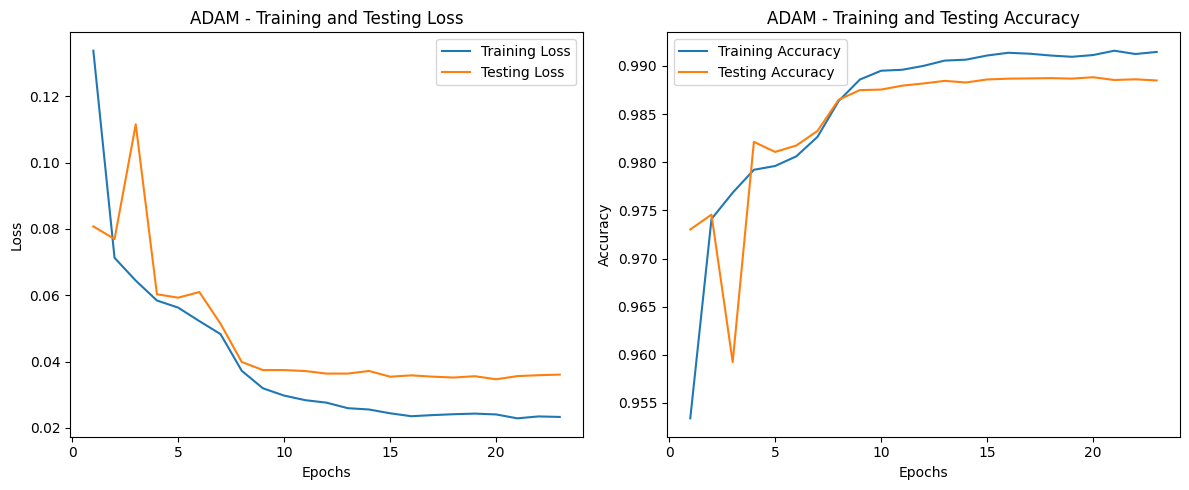

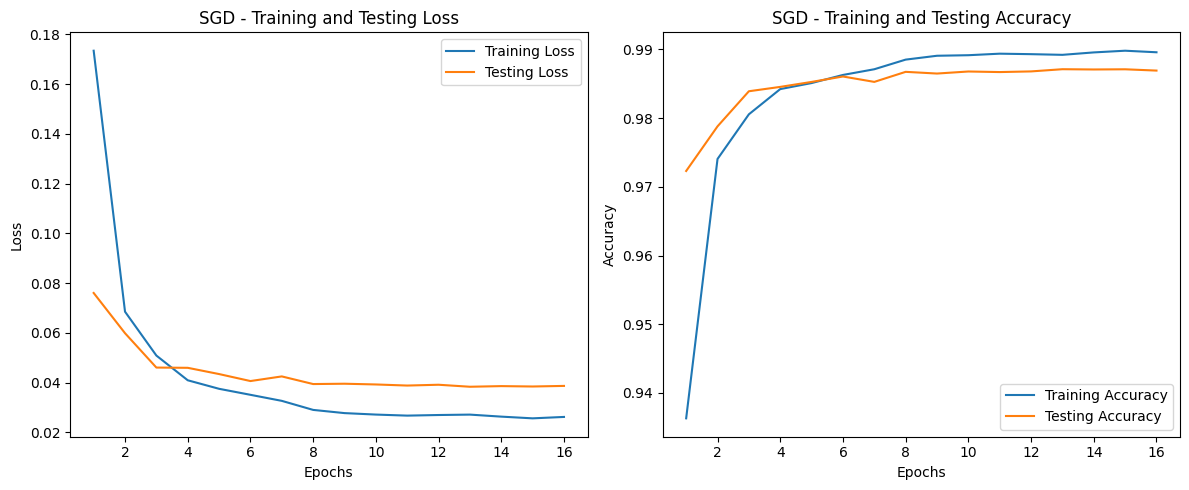

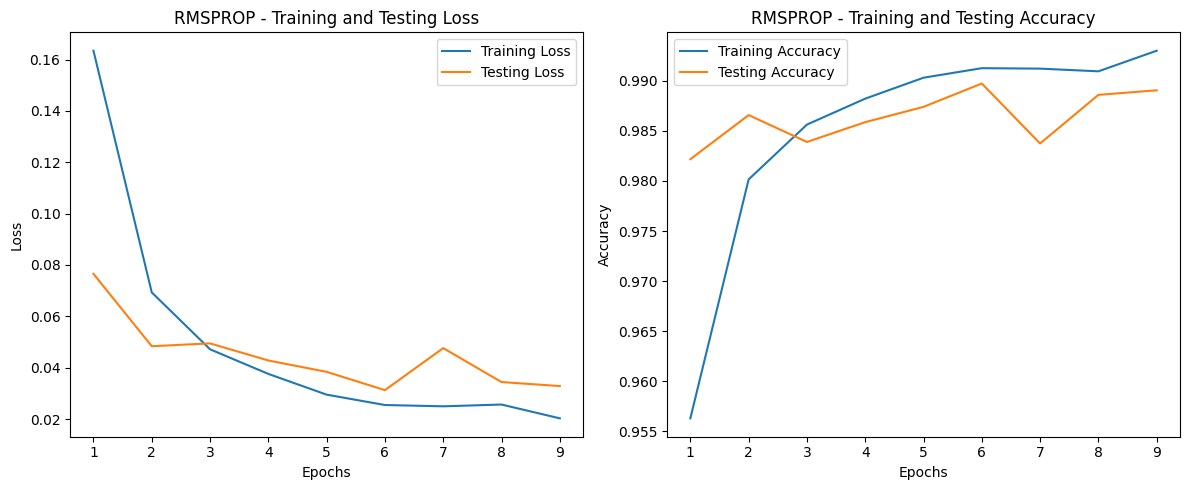

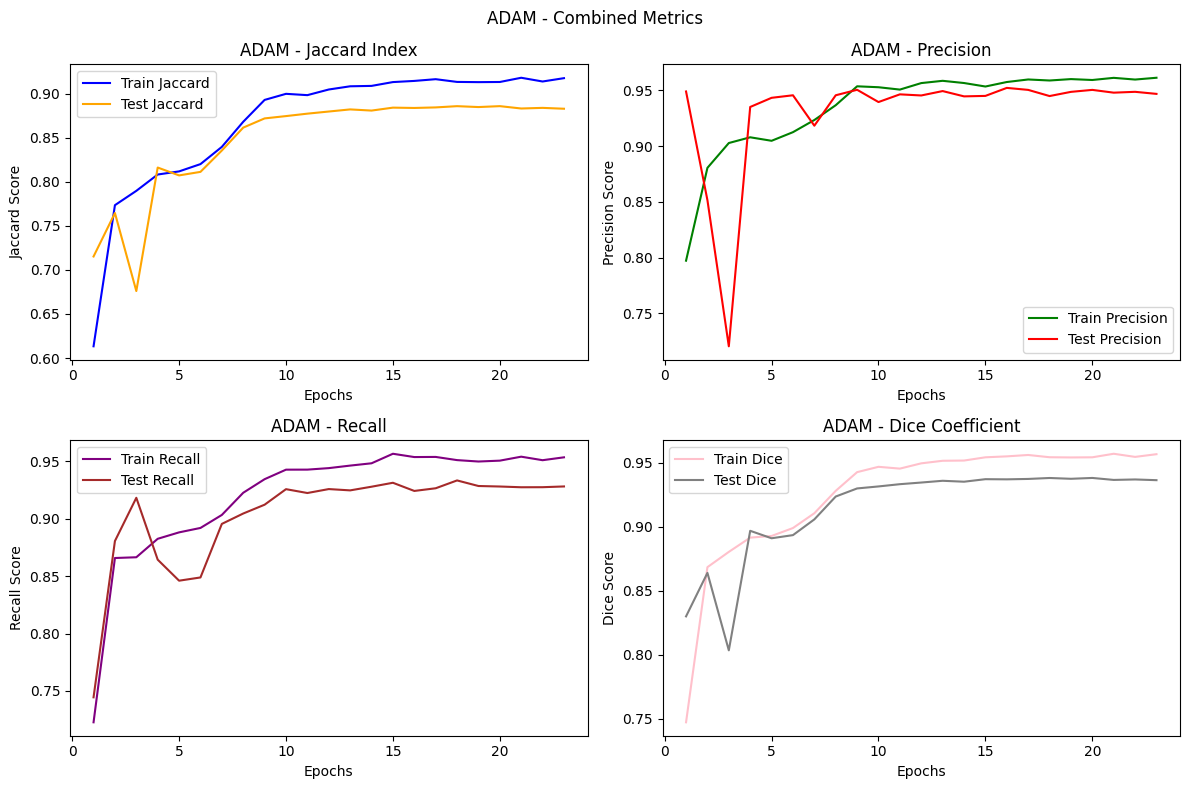

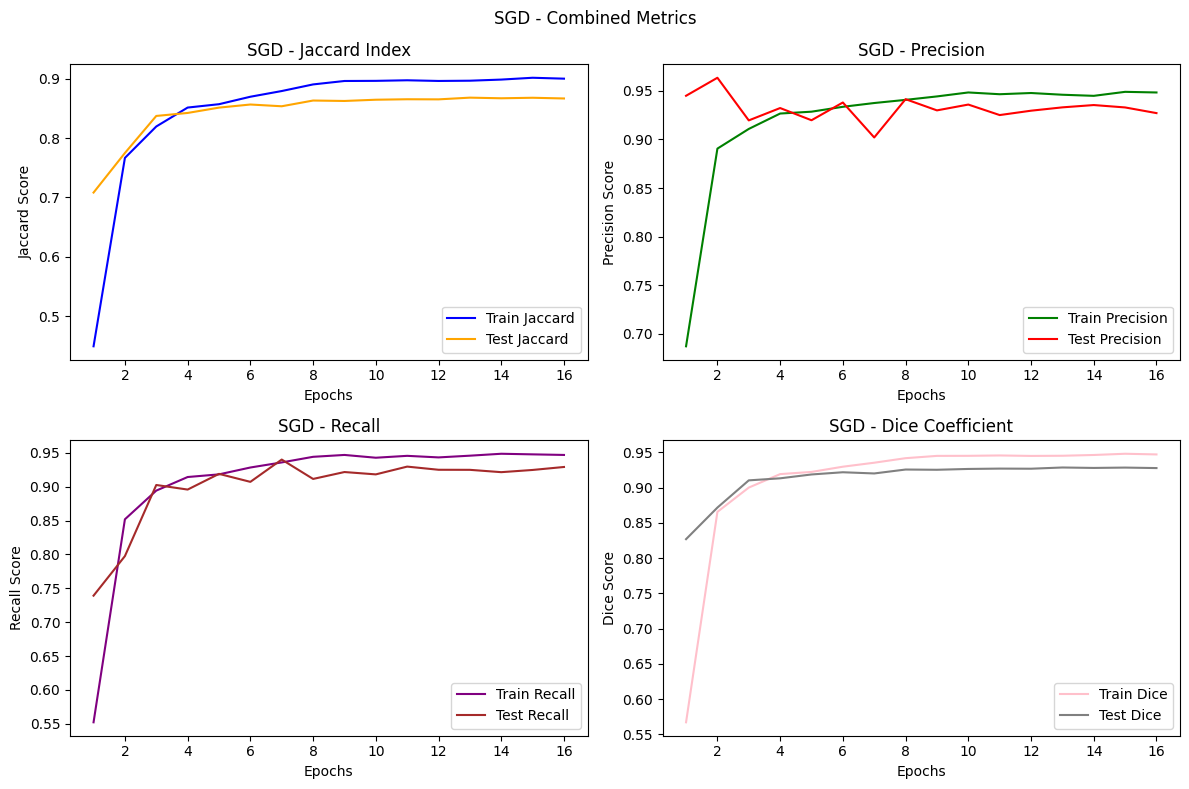

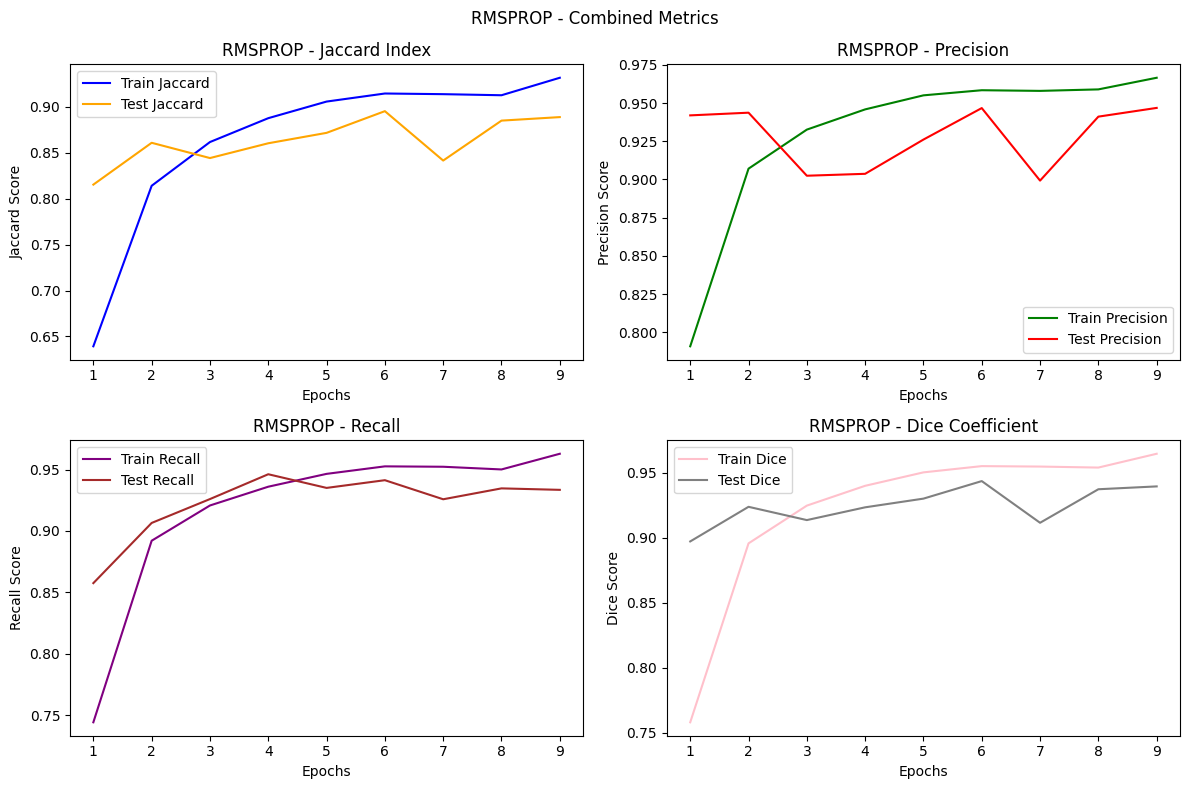

In [4]:
# Plot Loss and Accuracy for each optimizer
def plot_loss_and_accuracy(results):
    for optimizer_choice, metrics in results.items():
        train_losses = metrics['train_losses']
        test_losses = metrics['test_losses']
        train_accuracies = metrics['train_accuracies']
        test_accuracies = metrics['test_accuracies']

        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 5))

        # Plot Losses
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, test_losses, label='Testing Loss')
        plt.title(f'{optimizer_choice.upper()} - Training and Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Accuracies
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, test_accuracies, label='Testing Accuracy')
        plt.title(f'{optimizer_choice.upper()} - Training and Testing Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot combined metrics for each optimizer
def plot_combined_metrics(results):
    for optimizer_choice, metrics in results.items():
        train_jaccards = metrics['train_jaccards']
        test_jaccards = metrics['test_jaccards']
        train_precisions = metrics['train_precisions']
        test_precisions = metrics['test_precisions']
        train_recalls = metrics['train_recalls']
        test_recalls = metrics['test_recalls']
        train_dices = metrics['train_dices']
        test_dices = metrics['test_dices']

        epochs = range(1, len(train_jaccards) + 1)
        plt.figure(figsize=(12, 8))

        # Jaccard
        plt.subplot(2, 2, 1)
        plt.plot(epochs, train_jaccards, label='Train Jaccard', color='blue')
        plt.plot(epochs, test_jaccards, label='Test Jaccard', color='orange')
        plt.title(f'{optimizer_choice.upper()} - Jaccard Index')
        plt.xlabel('Epochs')
        plt.ylabel('Jaccard Score')
        plt.legend()

        # Precision
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_precisions, label='Train Precision', color='green')
        plt.plot(epochs, test_precisions, label='Test Precision', color='red')
        plt.title(f'{optimizer_choice.upper()} - Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision Score')
        plt.legend()

        # Recall
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_recalls, label='Train Recall', color='purple')
        plt.plot(epochs, test_recalls, label='Test Recall', color='brown')
        plt.title(f'{optimizer_choice.upper()} - Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall Score')
        plt.legend()

        # Dice
        plt.subplot(2, 2, 4)
        plt.plot(epochs, train_dices, label='Train Dice', color='pink')
        plt.plot(epochs, test_dices, label='Test Dice', color='gray')
        plt.title(f'{optimizer_choice.upper()} - Dice Coefficient')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()

        plt.suptitle(f'{optimizer_choice.upper()} - Combined Metrics')
        plt.tight_layout()
        plt.show()

# Call the functions with the updated results dictionary
plot_loss_and_accuracy(results)
plot_combined_metrics(results)

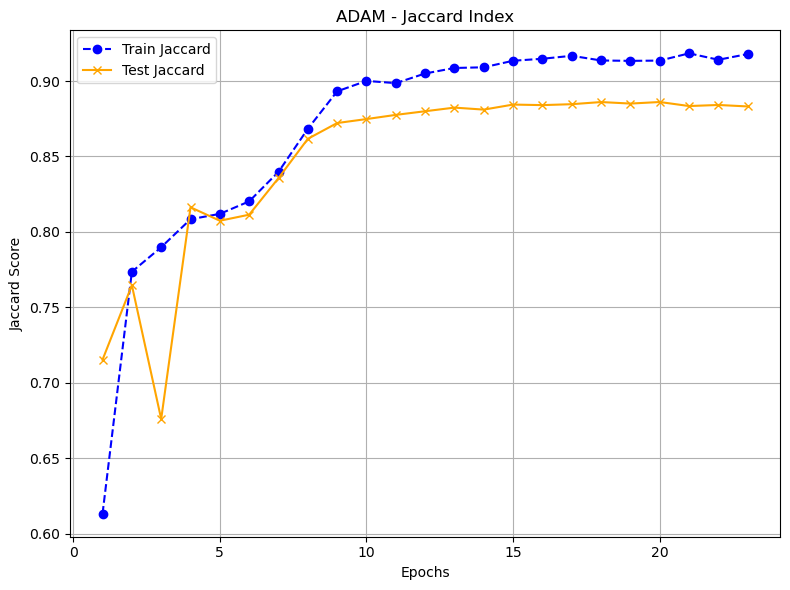

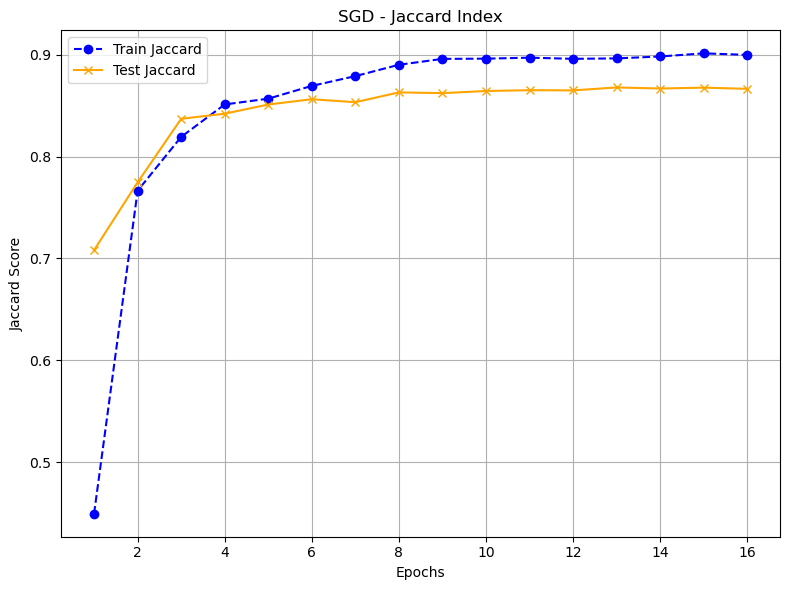

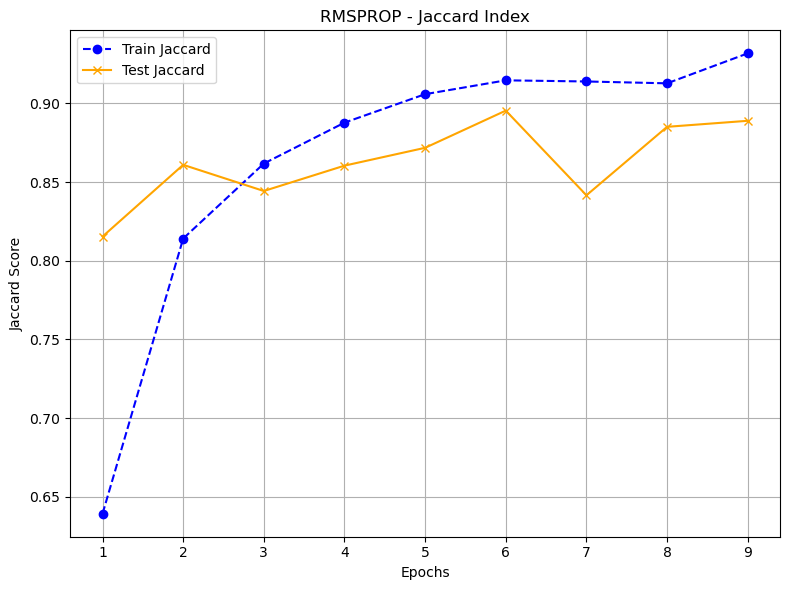

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


#         plt.plot(epochs, train_jaccards, label='Train Jaccard', color='blue', linestyle='--', marker='o')
#         plt.plot(epochs, test_jaccards, label='Test Jaccard', color='orange', linestyle='-', marker='x')

# Load the results from the CSV file
filename = "Exp4_res_18_11_20_52.csv"  # Replace with your actual file name
results_df = pd.read_csv(filename)

# Plot Jaccard Index for each optimizer
def plot_jaccard_from_csv(results_df):
    optimizers = results_df["Optimizer"].unique()
    
    for optimizer in optimizers:
        optimizer_data = results_df[results_df["Optimizer"] == optimizer]
        epochs = optimizer_data["Epoch"]
        train_jaccards = optimizer_data["Train Jaccard"]
        test_jaccards = optimizer_data["Test Jaccard"]

        plt.figure(figsize=(8, 6))

        # Jaccard Index
        plt.plot(epochs, train_jaccards, label='Train Jaccard', color='blue', linestyle='--', marker='o')
        plt.plot(epochs, test_jaccards, label='Test Jaccard', color='orange', linestyle='-', marker='x')
        plt.title(f'{optimizer.upper()} - Jaccard Index')
        plt.xlabel('Epochs')
        plt.ylabel('Jaccard Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Call the function
plot_jaccard_from_csv(results_df)

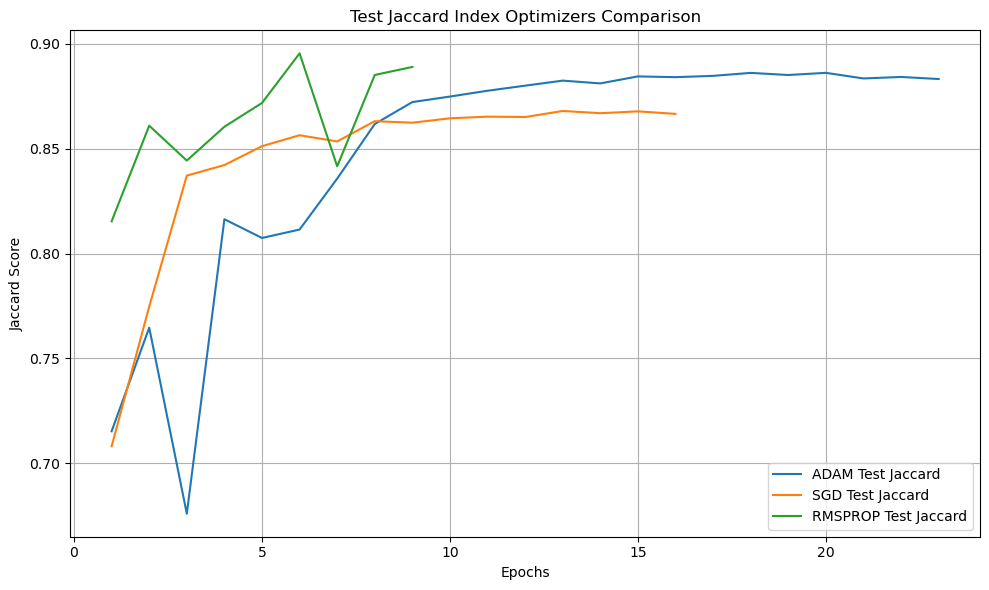

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
filename = "Exp4_res_18_11_20_52.csv"  # Replace with your actual file name
results_df = pd.read_csv(filename)

# Plot Test Jaccard results for all optimizers
def plot_test_jaccard(results_df):
    optimizers = results_df["Optimizer"].unique()
    plt.figure(figsize=(10, 6))

    # Plot a line for each optimizer
    for optimizer in optimizers:
        optimizer_data = results_df[results_df["Optimizer"] == optimizer]
        epochs = optimizer_data["Epoch"]
        test_jaccards = optimizer_data["Test Jaccard"]

        plt.plot(epochs, test_jaccards, label=f'{optimizer.upper()} Test Jaccard')

    # Add labels, title, legend, and grid
    plt.title('Test Jaccard Index Optimizers Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_test_jaccard(results_df)


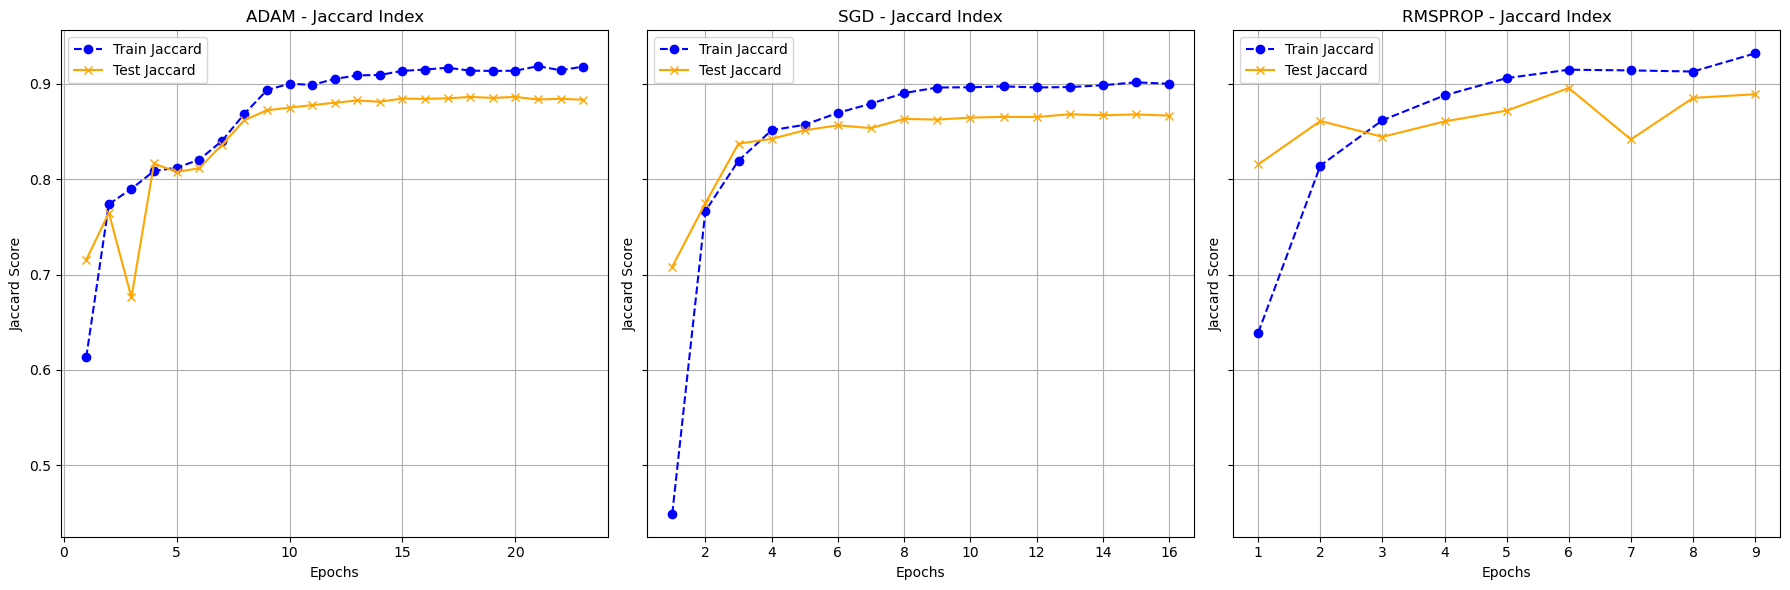

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
filename = "Exp4_res_18_11_20_52.csv"  # Replace with your actual file name
results_df = pd.read_csv(filename)

# Plot Jaccard Index for each optimizer in a 1x3 grid
def plot_jaccard_1x3(results_df):
    optimizers = results_df["Optimizer"].unique()
    num_optimizers = len(optimizers)
    
    # Create a figure with 1 row and `num_optimizers` columns
    fig, axes = plt.subplots(1, num_optimizers, figsize=(18, 6), sharey=True)
    
    if num_optimizers == 1:  # Handle case for single optimizer (axes will not be iterable)
        axes = [axes]
    
    for ax, optimizer in zip(axes, optimizers):
        optimizer_data = results_df[results_df["Optimizer"] == optimizer]
        epochs = optimizer_data["Epoch"]
        train_jaccards = optimizer_data["Train Jaccard"]
        test_jaccards = optimizer_data["Test Jaccard"]

        # Jaccard Index
        ax.plot(epochs, train_jaccards, label='Train Jaccard', color='blue', linestyle='--', marker='o')
        ax.plot(epochs, test_jaccards, label='Test Jaccard', color='orange', linestyle='-', marker='x')
        ax.set_title(f'{optimizer.upper()} - Jaccard Index')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Jaccard Score')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_jaccard_1x3(results_df)
